In [1]:
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb

### Basic Xgboost

In [2]:
bike_train = pd.read_csv('bike_demand_all_train.csv')

In [4]:
# bike_train.drop(columns=['Unnamed: 0','rent_place_num','rent_time'], inplace=True)
trainX = bike_train.drop(columns=['rent_freq'])
trainY = bike_train['rent_freq'].map(lambda x: np.log1p(x)).values

del bike_train
gc.collect()

21

In [ ]:
bike_test = pd.read_csv('bike_demand_all_test.csv')

In [6]:
# bike_test.drop(columns=['Unnamed: 0','rent_place_num','rent_time'], inplace=True)

testX = bike_test.drop(columns=['rent_freq'])
testY = bike_test['rent_freq'].values

del bike_test
gc.collect()

14

In [7]:
trainMatrix = xgb.DMatrix(trainX, label=trainY)
# trainMatrix.save_binary('bike_demand_all_train.buffer')

In [8]:
testMatrix = xgb.DMatrix(testX)
# testMatrix.save_binary('bike_demand_all_test.buffer')

In [9]:
# eta : learning_rate와 같다.
params = {'colsample_bytree': 1.0,
 'eta': 0.1,
 'gamma': 1.0,
 'max_depth': 5,
 'subsample': 0.5,
 'objective': 'reg:linear',
 'eval_metric': 'rmse',
 'tree_method': 'gpu_hist'}

num_rounds = 30

In [10]:
clf = xgb.train(params, trainMatrix, num_rounds)

In [11]:
pred = clf.predict(testMatrix)
pred = np.expm1(pred)

In [17]:
a = np.round(pred)

In [21]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(testY, a)
rmse = np.sqrt(mse)
print(rmse)

1.8403311329527454


In [13]:
clf.save_model('0001.model')

In [ ]:
pred.to_csv('xgboost_demand.csv', index=False)

### Bayesian Optimization

https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost

In [1]:
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from bayes_opt import BayesianOptimization

In [30]:
dtrain = xgb.DMatrix('bike_demand_train.buffer')
dtest = xgb.DMatrix('bike_demand_test.buffer')

[06:00:24] 11116440x4 matrix with 44465760 entries loaded from bike_demand_train.buffer
[06:00:24] 914400x4 matrix with 3657600 entries loaded from bike_demand_test.buffer


In [31]:
def xgb_evaluate(eta, max_depth, subsample, gamma, colsample_bytree):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': eta,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'tree_method':'gpu_hist'}
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=30, nfold=3)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [32]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {'eta': (0.01, 0.1),
                                             'max_depth': (3, 7), 
                                             'subsample': (0.5, 1), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.5, 1)})
# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  1        | -0.4078   |  0.8898   |  0.06977  |  0.9894   |  3.521    |  0.7607   |
|  2        | -0.4059   |  0.8359   |  0.07466  |  0.3788   |  4.012    |  0.7841   |
|  3        | -0.4056   |  0.8663   |  0.07381  |  0.2668   |  6.887    |  0.5175   |
|  4        | -0.4329   |  0.5156   |  0.03493  |  0.01656  |  6.988    |  0.9661   |
|  5        | -0.4042   |  1.0      |  0.1      |  0.0      |  3.0      |  0.5      |
|  6        | -0.4036   |  1.0      |  0.1      |  1.0      |  5.179    |  0.5      |
|  7        | -0.4944   |  1.0      |  0.01     |  0.0      |  5.254    |  0.5      |
|  8        | -0.405    |  0.5      |  0.1      |  1.0      |  7.0      |  0.5      |
CPU times: user 7min 2s, sys: 1min 32s, total: 8min 34s
Wall time: 8min 12s


In [34]:
params = xgb_bo.res[4]['params']

In [36]:
params

{'colsample_bytree': 1.0,
 'eta': 0.1,
 'gamma': 0.0,
 'max_depth': 3.0,
 'subsample': 0.5}

In [37]:
params['max_depth'] = int(params['max_depth'])

In [38]:
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['tree_method'] = 'gpu_hist'

In [33]:
# clf = xgb.train(params, dtrain, num_boost_round=50)
# clf.save_model('0003.model')

# pred = clf.predict(dtest)
# pred = np.expm1(pred)

In [39]:
params

{'colsample_bytree': 1.0,
 'eta': 0.1,
 'gamma': 0.0,
 'max_depth': 3,
 'subsample': 0.5,
 'objective': 'reg:linear',
 'eval_metric': 'rmse',
 'tree_method': 'gpu_hist'}

In [40]:
res = []
for i in range(10):
    clf = xgb.train(params, dtrain, num_boost_round=50)
    pred = clf.predict(dtest)
    pred = np.expm1(pred)
    res.append(pred)

In [41]:
test = pd.DataFrame(res[0])
for i in res[1:]:
    test = pd.concat([test, pd.DataFrame(i)], axis=1)

In [42]:
test.columns=['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']

In [43]:
test.to_csv('xgboost_demand.csv', index=False)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914400 entries, 0 to 914399
Data columns (total 10 columns):
1st     914400 non-null float32
2nd     914400 non-null float32
3rd     914400 non-null float32
4rd     914400 non-null float32
5th     914400 non-null float32
6th     914400 non-null float32
7th     914400 non-null float32
8th     914400 non-null float32
9th     914400 non-null float32
10th    914400 non-null float32
dtypes: float32(10)
memory usage: 34.9 MB


In [19]:
bike_test = pd.read_csv('bike_demand_addloc_test.csv')
testY = bike_test['rent_freq'].values

In [47]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(testY, test['4th'])
rmse = np.sqrt(mse)
print(rmse)

1.8500159243784526


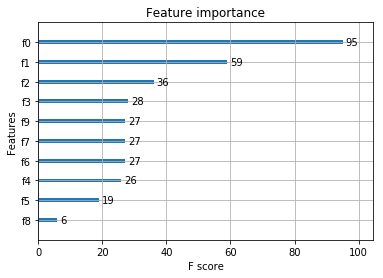

In [33]:
xgb.plot_importance(clf,max_num_features=10)

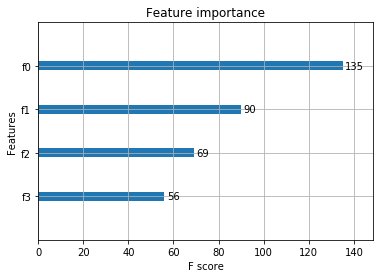

In [45]:
xgb.plot_importance(clf,max_num_features=10)